In [9]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data loading complete
Training set:(36000, 24)|Test set:(9000, 24)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Training set exported and downloaded: (36000, 25)
  Filename: loan_train.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test set exported and downloaded: (9000, 25)
  Filename: loan_test.csv
Removed feature:previous_loan_defaults_on_file
New feature count: 23
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best parameters: {'subsample': 0.85, 'reg_lambda': 0.8, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 0.2, 'colsample_bytree': 0.6}
 CV AUC: 0.9355
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Random Forest Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
 Random Forest CV AUC: 0.9210
Best threshold:0.647
Best threshold XGBoost:0.647
Best threshold RF:0.420

[XGBoost]
[Threshold=0.5] AUC=0.9393 | ACC=0.8904 | PREC=0.7302 | REC=0.8040 | F1=0.7653
[Threshold=0.647] ACC=0.9150 | PREC=0.8617 | REC=0.7355 | F1=0.7936

[Random Forest]
[Threshold=0.5] AUC=0.9258 | ACC=0.9054 | PREC=0.8606 | REC=0.6855 | F1=0.7632
[Threshold=0.420] ACC=0.902

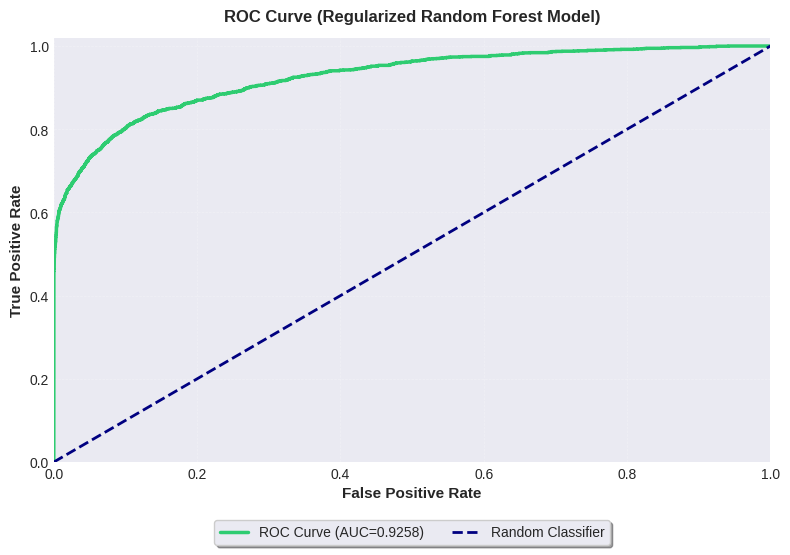

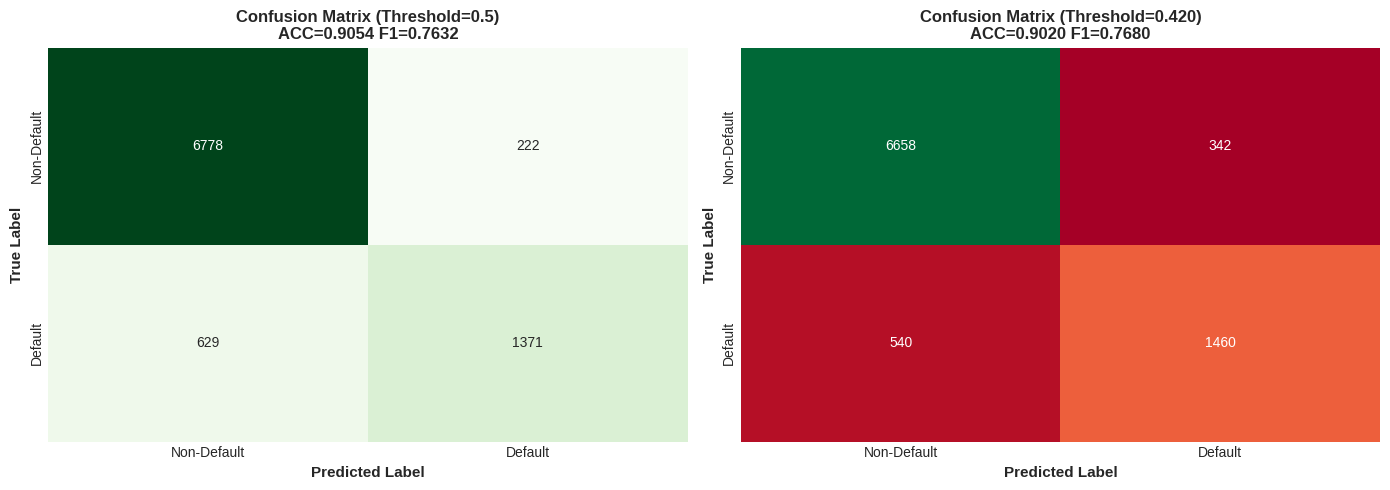

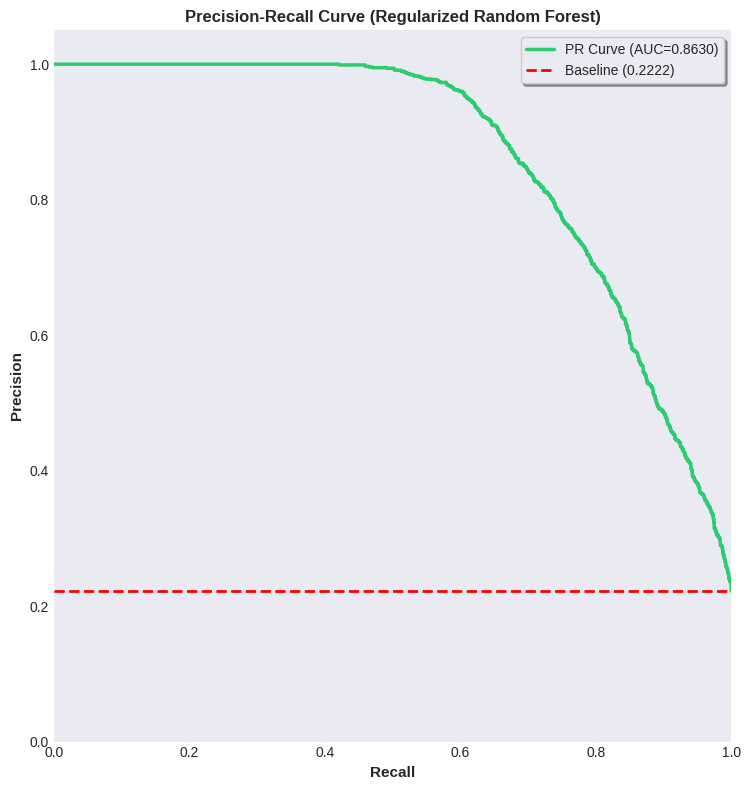

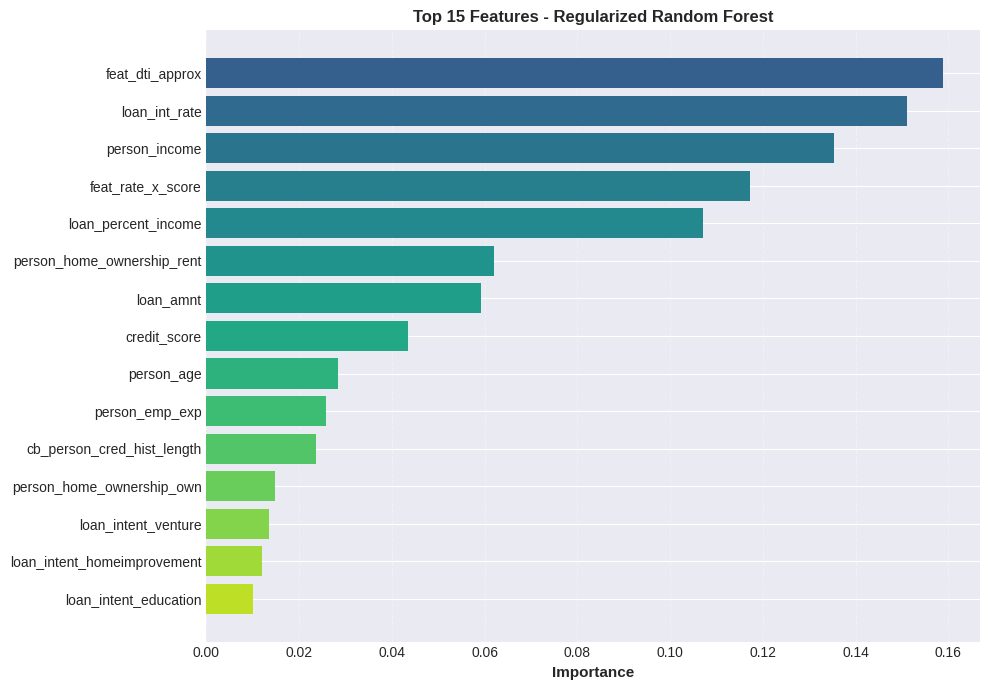

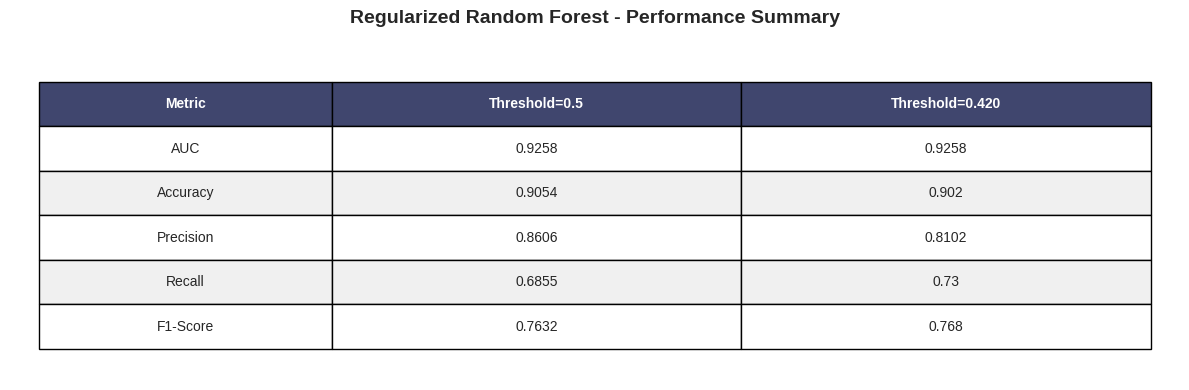

In [11]:
%run /content/drive/MyDrive/INT3095Loan_Default_Project/INT3095_Model_Training_and_Evaluation.ipynb

In [12]:
print(" Model Type:",type(model_rf))
print(" Test Set Shape:",X_test_drop.shape)
print(" Best Threshold:",best_thr_rf)
print(" Risk Score Sample:",model_rf.predict_proba(X_test_drop)[:3, 1])
print("\nAll variables inherited successfully")

 Model Type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 Test Set Shape: (9000, 23)
 Best Threshold: 0.4199578377340324
 Risk Score Sample: [0.005649   0.04518379 0.00033429]

All variables inherited successfully


In [13]:
sns.set_style("whitegrid")

In [14]:
print("1.Financial Feature Importance Analysis")

1.Financial Feature Importance Analysis


In [15]:
imp = pd.Series(model_rf.feature_importances_, index=X_test_drop.columns).sort_values(ascending=False)

In [16]:
dim_map = {
    "Income": ["person_income", "loan_percent_income", "feat_dti_approx"],
    "Debt": ["loan_amnt", "loan_int_rate", "feat_dti_approx"],
    "Credit": ["credit_score", "cb_person_cred_hist_length", "person_age"],
    "History": ["previous_loan_defaults_on_file", "person_emp_exp"],
}

In [17]:
dim_imp = pd.Series({k: imp[imp.index.intersection(v)].sum() for k, v in dim_map.items()}).sort_values(ascending=False)


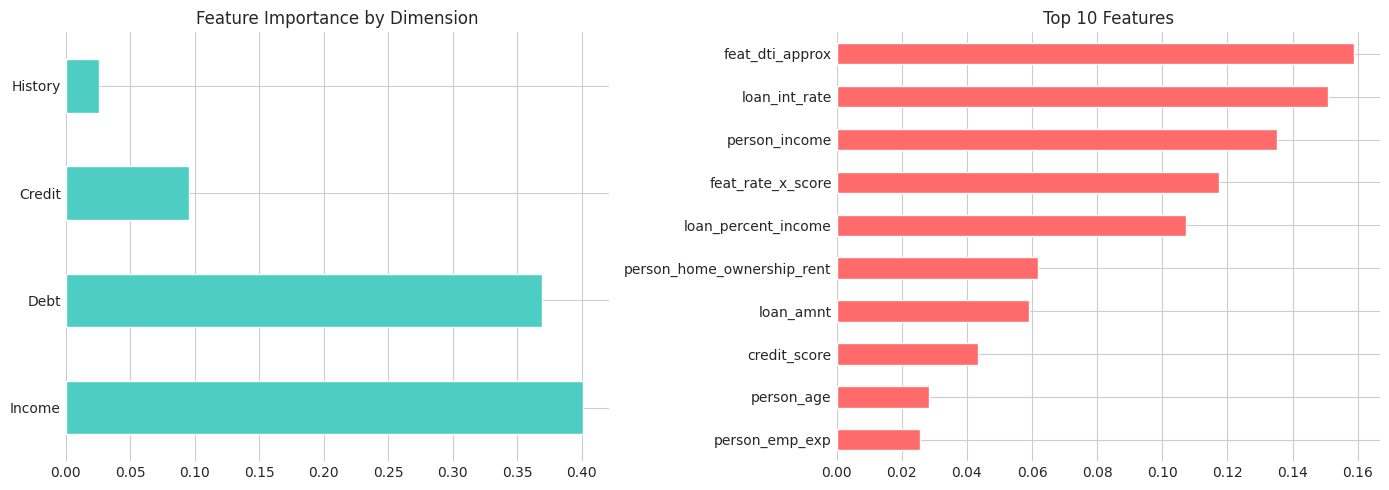

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
dim_imp.plot(kind="barh", ax=ax1, color="#4ecdc4"); ax1.set_title("Feature Importance by Dimension")
imp.head(10).iloc[::-1].plot(kind="barh", ax=ax2, color="#ff6b6b"); ax2.set_title("Top 10 Features")
plt.tight_layout(); plt.savefig("d1_importance.png", dpi=300); plt.show()

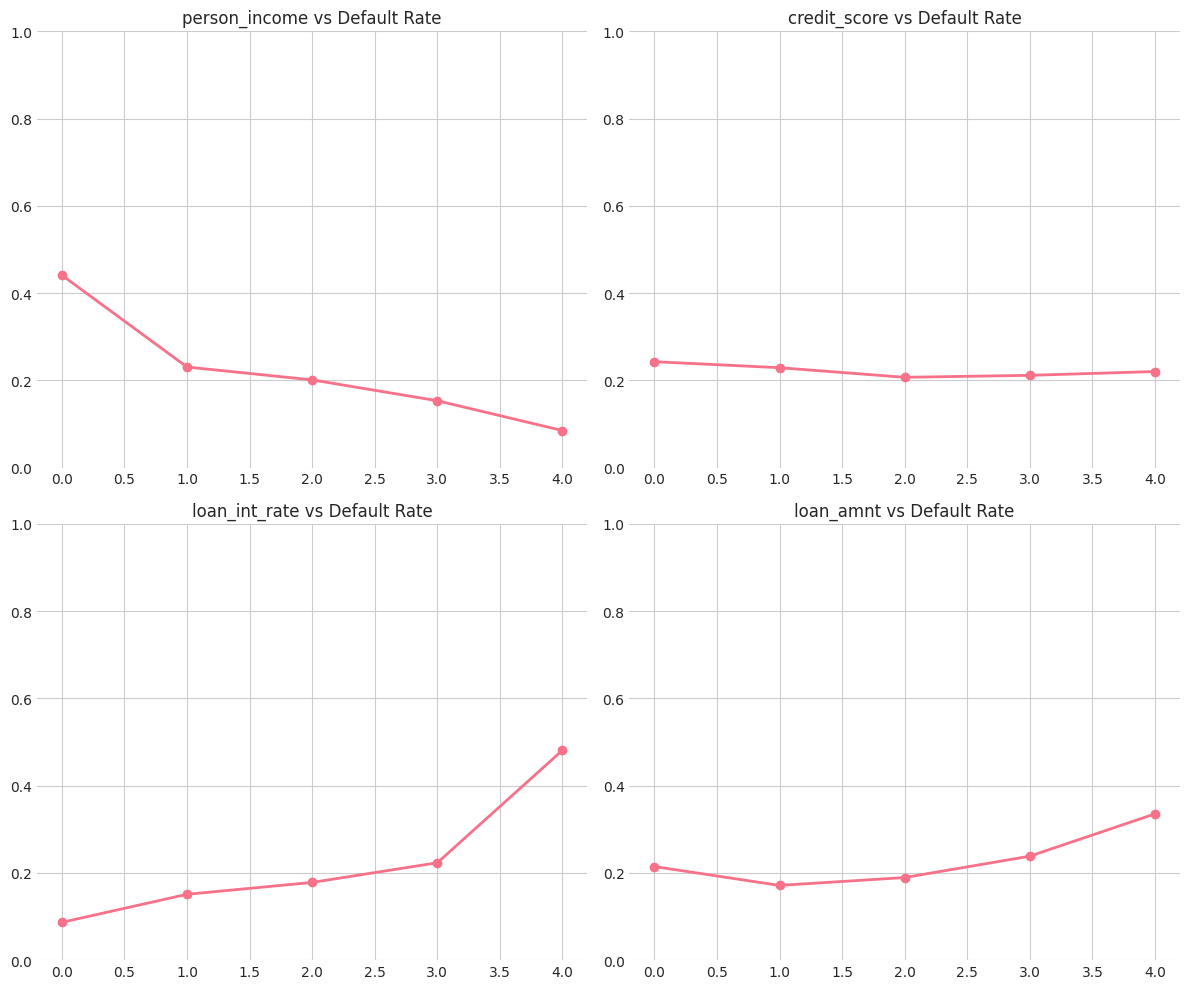

In [19]:
n = 4; fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, f in enumerate(["person_income", "credit_score", "loan_int_rate", "loan_amnt"]):
    if f in X_test_drop.columns:
        tmp = pd.DataFrame({f: X_test_drop[f], "y": y_test.values}).dropna()
        tmp["bin"] = pd.qcut(tmp[f], q=5, duplicates="drop")
        g = tmp.groupby("bin")["y"].mean()
        axes[i//2, i%2].plot(range(len(g)), g.values, marker="o", linewidth=2)
        axes[i//2, i%2].set_title(f"{f} vs Default Rate"); axes[i//2, i%2].set_ylim(0, 1)
plt.tight_layout(); plt.savefig("d1_default_bins.png", dpi=300); plt.show()

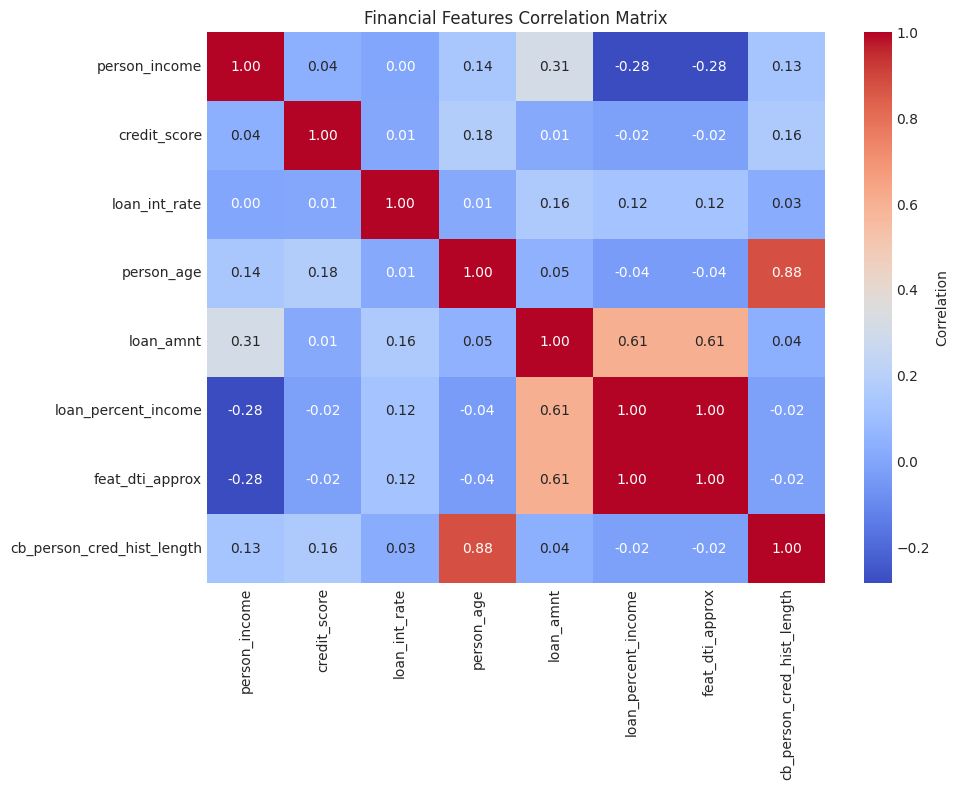

In [20]:
corr_feats = [c for c in ["person_income", "credit_score", "loan_int_rate", "person_age",
                           "loan_amnt", "loan_percent_income", "feat_dti_approx",
                           "cb_person_cred_hist_length"] if c in X_test_drop.columns]
plt.figure(figsize=(10, 8))
sns.heatmap(X_test_drop[corr_feats].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Financial Features Correlation Matrix"); plt.tight_layout(); plt.savefig("d1_corr_heatmap.png", dpi=300); plt.show()

In [21]:
print("2.Risk Stratification Analysis")

2.Risk Stratification Analysis


In [34]:
y_true=y_test.values
risk_score=model_rf.predict_proba(X_test_drop)[:,1]

In [35]:
risk_df = X_test_drop.copy()
risk_df["y"] = y_true
risk_df["score"] = risk_score

In [36]:
risk_df["level"] = pd.qcut(risk_df["score"],q=5,duplicates="drop")
risk_df["level_name"] =pd.cut(risk_df["level"].cat.codes,
                                bins=[-1,0,1,2,3,4],
                                labels=["Very Low","Low", "Medium","High","Very High"])

In [37]:
agg = risk_df.groupby("level_name", observed=True).agg(
    default_rate=("y","mean"),
    count=("y","size"),
    income=("person_income","mean"),
    credit=("credit_score","mean"),
    rate=("loan_int_rate","mean"),
    amount=("loan_amnt","mean"))

In [38]:
print(agg.round(3));print()

            default_rate  count     income   credit    rate     amount
level_name                                                            
Very Low           0.012   1800  98911.782  633.285   8.221   8777.103
Low                0.031   1800  92356.193  634.158   9.815   9633.981
Medium             0.077   1800  81191.629  631.964  10.787   9233.089
High               0.181   1800  67526.777  631.473  12.458   8649.333
Very High          0.810   1800  57000.562  631.346  13.620  11546.174



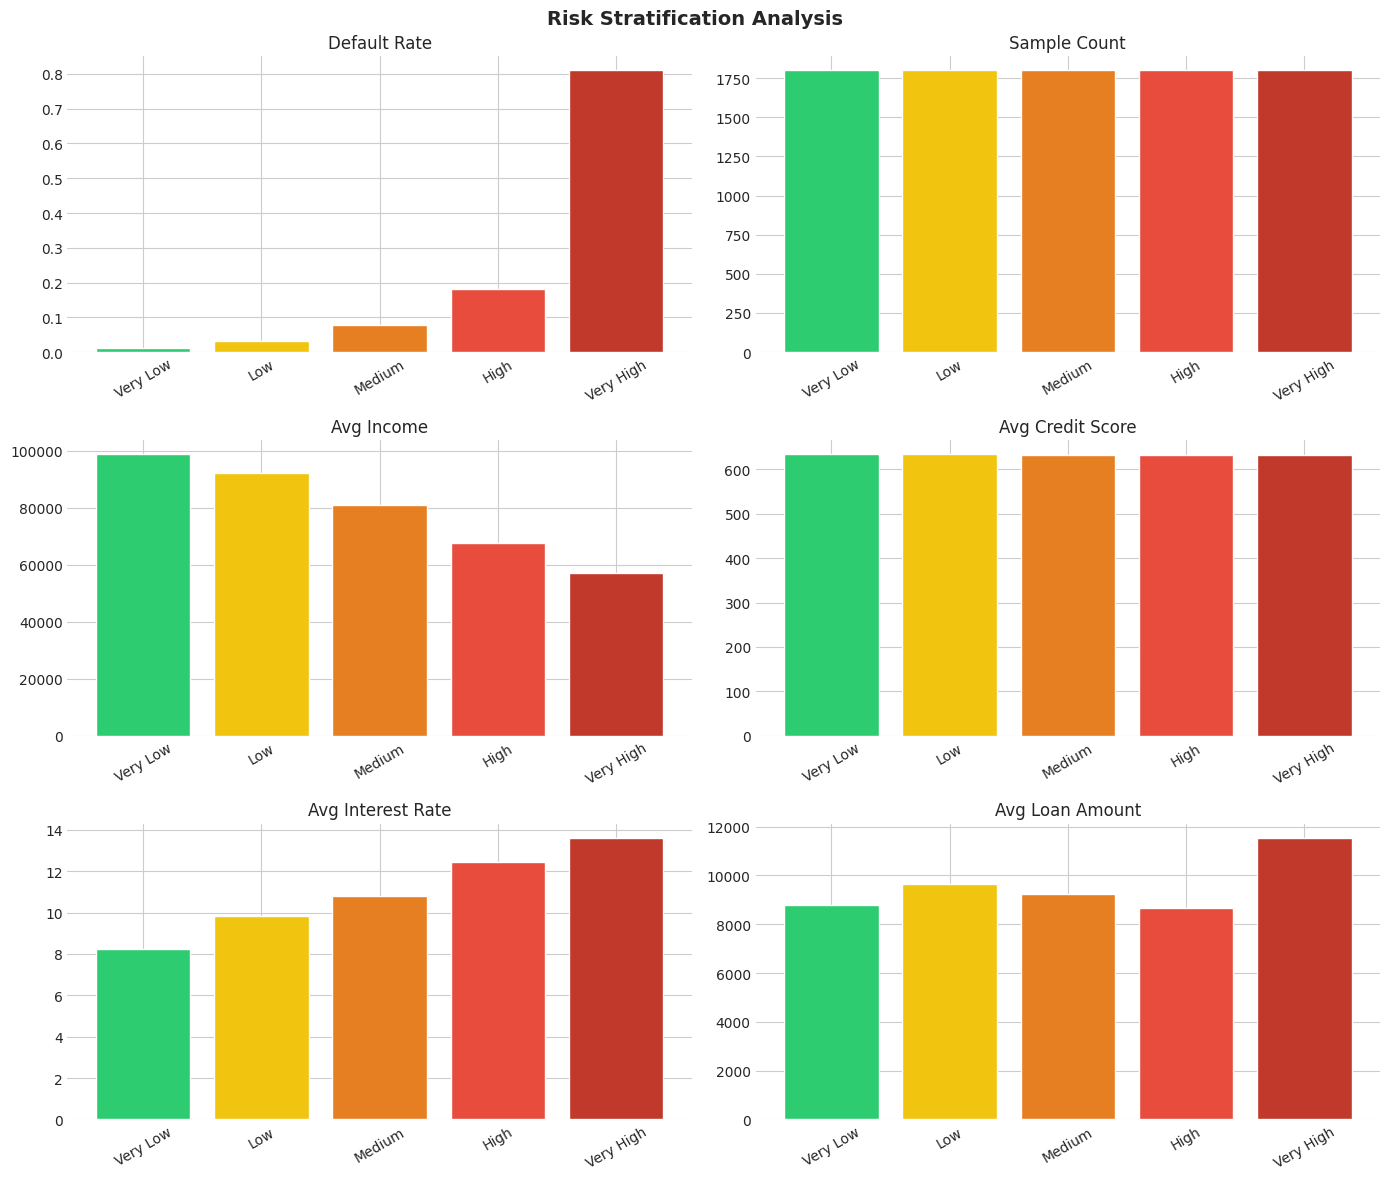

In [39]:
fig, axes = plt.subplots(3,2,figsize=(14,12))
axes = axes.flatten()
for i, (m,t) in enumerate(zip(
    ["default_rate", "count", "income", "credit", "rate", "amount"],
    ["Default Rate", "Sample Count", "Avg Income", "Avg Credit Score",
     "Avg Interest Rate", "Avg Loan Amount"])):
    axes[i].bar(range(len(agg)),agg[m].values,
                color=["#2ecc71","#f1c40f","#e67e22","#e74c3c","#c0392b"])
    axes[i].set_xticks(range(len(agg)))
    axes[i].set_xticklabels(agg.index,rotation=30)
    axes[i].set_title(t)

plt.suptitle("Risk Stratification Analysis", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("d2_risk_layers.png", dpi=300)
plt.show()

In [40]:
print("3.Risk Pricing Strategy")

3.Risk Pricing Strategy


In [41]:
base_rate = 5.0
risk_premium=[0.5,1.5,3.5,6.0,9.5]
final_rate=[base_rate + p for p in risk_premium]
max_amount=[35000,30000,20000,12000,5000]
n_risks = len(agg.index)

In [42]:
pricing = pd.DataFrame({
    "Risk_Level": agg.index.tolist(),
    "Default_Rate_%": np.round(agg["default_rate"].values * 100,1),
    "Base_Rate_%": [base_rate] * n_risks,
    "Risk_Premium_%": risk_premium[:n_risks],
    "Final_Rate_%": final_rate[:n_risks],
    "Max_Loan_Amount": max_amount[:n_risks],})
pricing.to_csv("d3_pricing_framework.csv", index=False)
print(pricing)
print()

  Risk_Level  Default_Rate_%  Base_Rate_%  Risk_Premium_%  Final_Rate_%  \
0   Very Low             1.2          5.0             0.5           5.5   
1        Low             3.1          5.0             1.5           6.5   
2     Medium             7.7          5.0             3.5           8.5   
3       High            18.1          5.0             6.0          11.0   
4  Very High            81.0          5.0             9.5          14.5   

   Max_Loan_Amount  
0            35000  
1            30000  
2            20000  
3            12000  
4             5000  



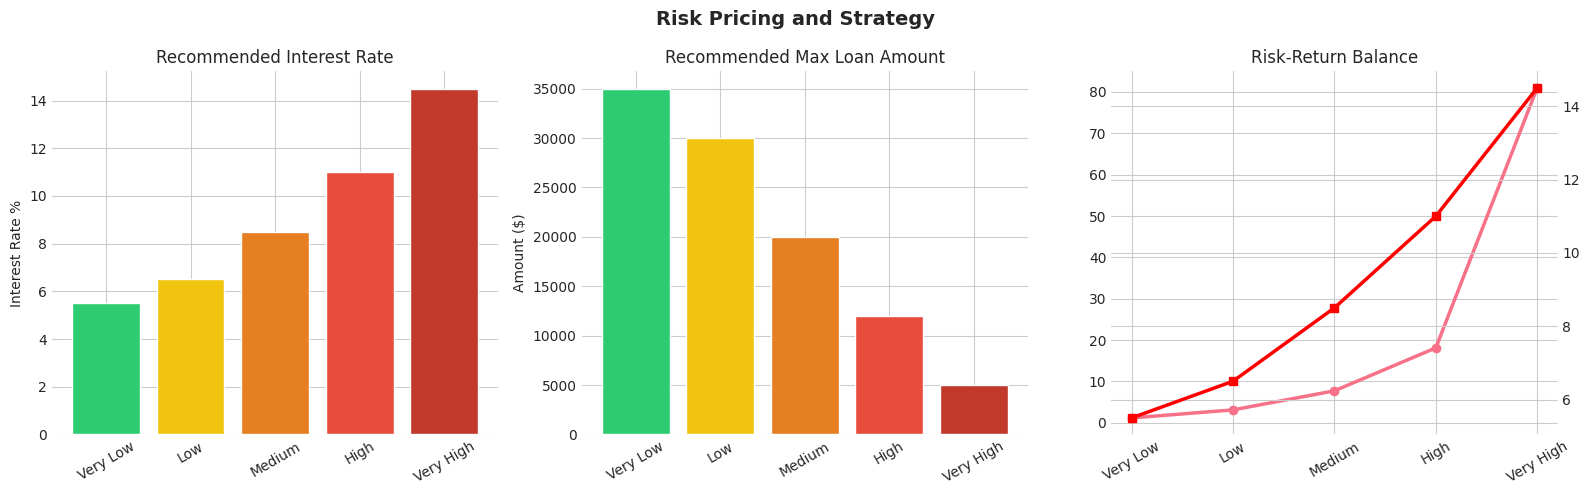

In [43]:
colors=["#2ecc71","#f1c40f","#e67e22","#e74c3c","#c0392b"][:n_risks]
fig,axes = plt.subplots(1,3,figsize=(16,5))

axes[0].bar(range(n_risks),final_rate[:n_risks],color=colors)
axes[0].set_xticks(range(n_risks))
axes[0].set_xticklabels(agg.index, rotation=30)
axes[0].set_title("Recommended Interest Rate")
axes[0].set_ylabel("Interest Rate %")

axes[1].bar(range(n_risks), max_amount[:n_risks], color=colors)
axes[1].set_xticks(range(n_risks))
axes[1].set_xticklabels(agg.index, rotation=30)
axes[1].set_title("Recommended Max Loan Amount")
axes[1].set_ylabel("Amount ($)")

axes[2].plot(range(n_risks), agg["default_rate"].values * 100, marker="o", linewidth=2.5)
ax2 = axes[2].twinx()
ax2.plot(range(n_risks), final_rate[:n_risks], marker="s", linewidth=2.5, color="red")
axes[2].set_xticks(range(n_risks))
axes[2].set_xticklabels(agg.index, rotation=30)
axes[2].set_title("Risk-Return Balance")

plt.suptitle("Risk Pricing and Strategy",fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("d3_pricing_plots.png",dpi=300)
plt.show()

In [44]:
print("4.Model Blind Spots and Improvement Suggestions")

4.Model Blind Spots and Improvement Suggestions


In [45]:
y_pred=(risk_score >= best_thr_rf).astype(int)
fp=(y_pred==1)&(y_test==0)
fn=(y_pred==0)&(y_test==1)
tn=(y_pred==0)&(y_test==0)
tp=(y_pred==1)&(y_test==1)


In [46]:
print(f"Confusion Matrix:TN={tn.sum()},TP={tp.sum()},FP={fp.sum()},FN={fn.sum()}\n")

Confusion Matrix:TN=6658,TP=1460,FP=342,FN=540



          Issue        Recommendation Priority
0   Too Many FP      Adjust threshold     High
1   Too Many FN  Weight risk features     High
2  Feature Gaps   Add behavioral data   Medium


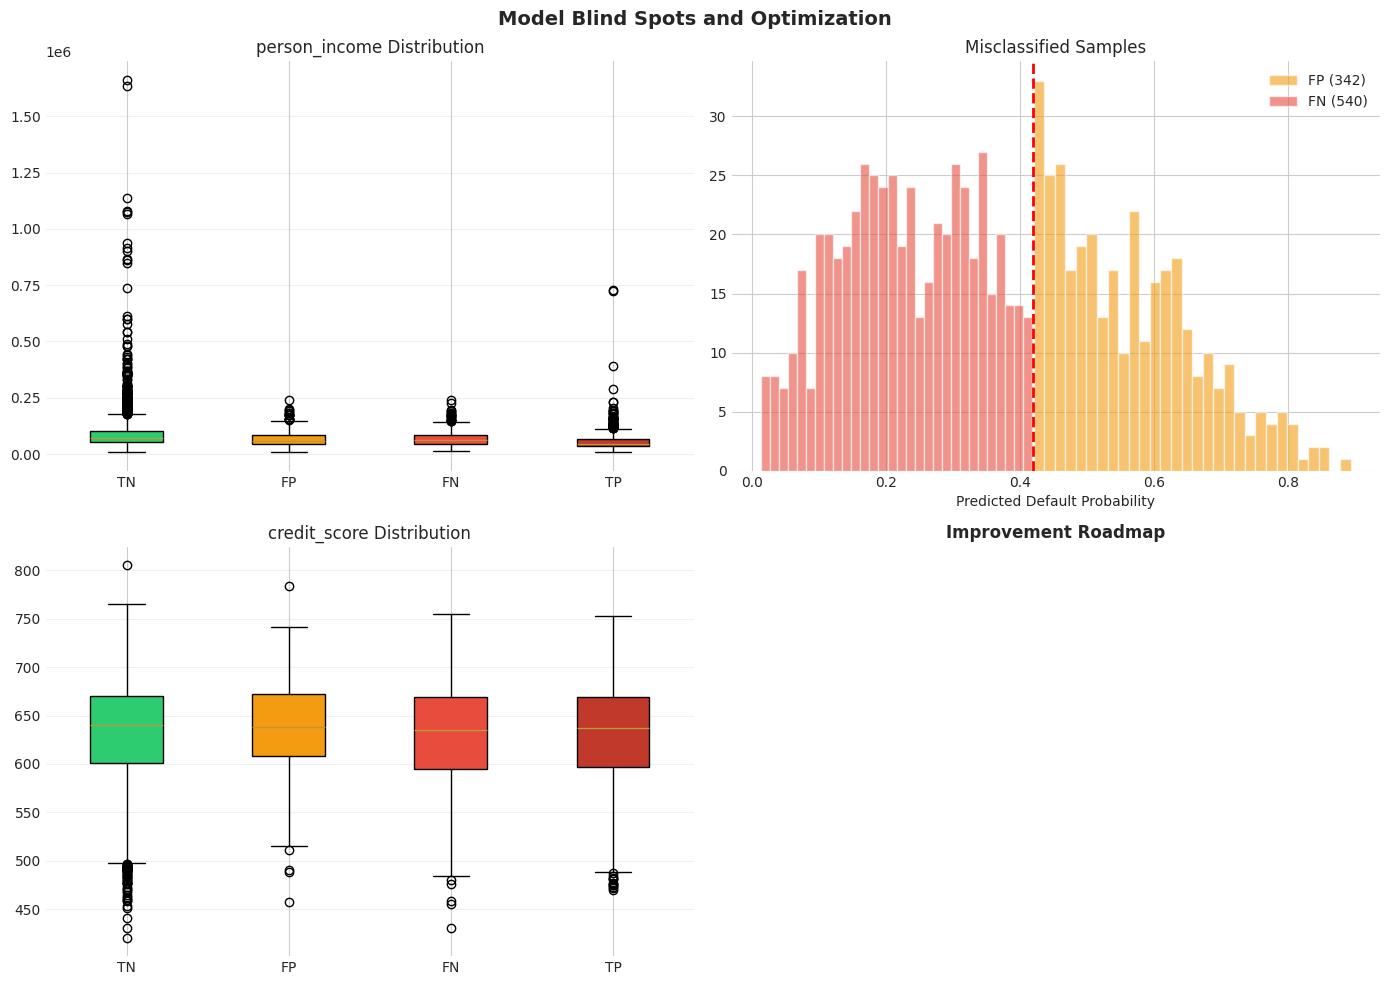

In [50]:
fig, axes = plt.subplots(2,2,figsize=(14,10))
for i,(f,title) in enumerate([("person_income","Income"),("credit_score","Credit Score")]):
    if f in X_test_drop.columns:
        data =[X_test_drop.loc[tn,f],X_test_drop.loc[fp, f],
                X_test_drop.loc[fn,f], X_test_drop.loc[tp, f]]
        bp = axes[i,0].boxplot(data,labels=["TN","FP","FN","TP"], patch_artist=True)
        for patch, color in zip(bp['boxes'],['#2ecc71','#f39c12','#e74c3c','#c0392b']):
            patch.set_facecolor(color)
        axes[i,0].set_title(f"{f} Distribution")
        axes[i,0].grid(axis='y',alpha=0.3)

axes[0,1].hist(risk_score[fp],bins=30,alpha=0.6,label=f"FP ({fp.sum()})",color='#f39c12')
axes[0,1].hist(risk_score[fn],bins=30,alpha=0.6,label=f"FN ({fn.sum()})",color='#e74c3c')
axes[0,1].axvline(best_thr_rf, color="red", linestyle="--",linewidth=2)
axes[0,1].set_title("Misclassified Samples")
axes[0,1].set_xlabel("Predicted Default Probability")
axes[0,1].legend()

improvement =pd.DataFrame({
    "Issue": ["Too Many FP","Too Many FN","Feature Gaps"],
    "Recommendation": ["Adjust threshold","Weight risk features","Add behavioral data"],
    "Priority": ["High","High","Medium"]})
improvement.to_csv("d4_improvement.csv",index=False)
print(improvement)

axes[1,1].axis('off')
axes[1,1].set_title("Improvement Roadmap", fontweight='bold')

plt.suptitle("Model Blind Spots and Optimization",fontsize=14,fontweight='bold')
plt.tight_layout()
plt.savefig("d4_blind_spots.png",dpi=300)
plt.show()

Dimensions 2 to 4 Complete